In [1]:
import sys

import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely.geometry

import numpy as np
import matplotlib.pyplot as plt
import seaborn

sys.path.append('../../src/construct/')
import util

data_path = '../../data'
build_path = '../../build'
idx = pd.IndexSlice

In [2]:
nuts2 = gpd.read_file(f'{build_path}/administrative-borders-nuts.gpkg', layer='nuts2')
nuts3 = gpd.read_file(f'{build_path}/administrative-borders-nuts.gpkg', layer='nuts3')
nuts3['nuts2'] = nuts3.id.str[:-1]
nuts2 = nuts2[nuts2.country_code == 'GBR']
nuts3 = nuts3[nuts3.country_code == 'GBR']

In [211]:
elec_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853754/Sub-national_electricity_consumption_statistics_2005-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
elec_lau1_con_all = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'All')].dropna()
elec_lau1_con_all.index = elec_lau1_con_all.index.rename('LA Code')

elec_lau1_con_dom = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Domestic consumers', 'All domestic')].dropna()
elec_lau1_con_dom.index = elec_lau1_con_dom.index.rename('LA Code')


elec_lau1_con_nondom = elec_lau1_con.set_index(
    ('Sub-national electricity sales and numbers of customers, 2017(1)', 'Unnamed: 2_level_1', 'LA Code')
)[('Sales (GWh)', 'Non-domestic consumers', 'All non-domestic')].dropna()
elec_lau1_con_nondom.index = elec_lau1_con_nondom.index.rename('LA Code')

gas_lau1_con = pd.read_excel(
    'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/853430/Sub-national_gas_consumption_statistics_2005-2018.xlsx',
    sheet_name='2017r', header=[0, 1, 2]
)
gas_lau1_con_all = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 10_level_1', 'Total consumption')].dropna(), errors='coerce')
gas_lau1_con_all.index = gas_lau1_con_all.index.rename('LA Code')

gas_lau1_con_dom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 8_level_1', 'Domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_dom.index = gas_lau1_con_dom.index.rename('LA Code')


gas_lau1_con_nondom = pd.to_numeric(gas_lau1_con.set_index(
    ('Sub-national gas sales and numbers of customers, 2017', 'Unnamed: 3_level_1', 'LA Code')
)[('Sales (GWh)', 'Unnamed: 9_level_1', 'Non-domestic consumption')].dropna(), errors='coerce')
gas_lau1_con_nondom.index = gas_lau1_con_nondom.index.rename('LA Code')

# Shapefile of the LAU1 units
uk_lau1_units = gpd.read_file('https://opendata.arcgis.com/datasets/69cd46d7d2664e02b30c2f8dcc2bfaf7_0.geojson')
uk_lau1_units = uk_lau1_units.set_index('LAD19CD')[['LAD19NM', 'geometry']]
uk_lau1_units.index = uk_lau1_units.index.rename('LA Code')

# Population data of LAU1 units
lau_conversion_2018 = pd.read_excel(
    'https://ec.europa.eu/eurostat/documents/345175/501971/EU-28-LAU-2018-NUTS-2016.xlsx',
    sheet_name='UK', header=0
)
pop_2018 = lau_conversion_2018.set_index('LAU NAME NATIONAL')

pop_2018 = pop_2018.reindex(uk_lau1_units.LAD19NM).set_index(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_all = gas_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_dom = gas_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
gas_lau1_con_nondom = gas_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_all = elec_lau1_con_all.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_dom = elec_lau1_con_dom.reindex(uk_lau1_units.index).dropna(how='all')
elec_lau1_con_nondom = elec_lau1_con_nondom.reindex(uk_lau1_units.index).dropna(how='all')


uk_lau1_units = uk_lau1_units.reindex(gas_lau1_con_all.index).assign(
    population=pop_2018['POPULATION'], 
    nuts3=pop_2018['NUTS 3 CODE'], 
    area_m2=pop_2018['TOTAL AREA (m2)'],
    city=(~pop_2018['CITY_NAME'].isnull()).astype('float'),
    gas_con_all=gas_lau1_con_all / 1000,
    gas_con_dom=gas_lau1_con_dom / 1000,
    gas_con_nondom=gas_lau1_con_nondom / 1000,
    elec_con_all=elec_lau1_con_all / 1000,
    elec_con_dom=elec_lau1_con_dom / 1000,
    elec_con_nondom=elec_lau1_con_nondom / 1000
)
uk_lau1_units['pop_density'] = uk_lau1_units['population'] / uk_lau1_units['area_m2']

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2867: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [27]:
energy_balances = pd.read_csv(build_path + '/build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(data_path + '/energy_balance_carrier_names.csv', index_col=0)
_subsectors = subsectors.jrc_idees.dropna().to_dict()
_subsectors['FC_IND_NFM_E'] = 'Metals'
_subsectors['FC_IND_IS_E'] = 'Metals'
_subsectors['FC_IND_PPP_E'] = 'Wood and paper'
_subsectors['FC_IND_WP_E'] = 'Wood and paper'

industry_energy_balances = (
    energy_balances
    .xs(('UK', 2014, 'TJ'), level=('country', 'year', 'unit'))
    .apply(util.tj_to_twh)
    .loc[['FC_IND_E', 'FC_OTH_CP_E'], ['G3000', 'E7000']]
    .groupby([subsectors.sub_cat_2.fillna(subsectors.sub_cat_1).to_dict(), carriers.carrier_name.to_dict()], level=[0, 1]).sum()
    .rename_axis(index=['sector', 'carrier'])
)

In [30]:
la_to_nuts3 = gpd.overlay(
    gpd.GeoDataFrame(data=uk_lau1_units.nuts3, 
                     geometry=uk_lau1_units.to_crs('epsg:3035').centroid, 
                     crs='epsg:3035').reset_index(), 
    nuts3.to_crs('epsg:3035')
)

In [216]:
uk_lau1_units.nuts3[~uk_lau1_units.nuts3.isin(nuts3.id)]

LA Code
E06000058      NaN
E06000059      NaN
E07000066    UKH37
E07000067    UKH34
E07000068    UKH36
             ...  
S12000045    UKM81
S12000047    UKM72
S12000048    UKM77
S12000049    UKM82
S12000050    UKM84
Name: nuts3, Length: 148, dtype: object

In [116]:
uk_lau1_units['nuts3'] = la_to_nuts3.set_index('LA Code').id
uk_lau1_units['nuts2'] = la_to_nuts3.set_index('LA Code').nuts2

Text(0.5, 1.0, 'Electricity consumption - NUTS2')

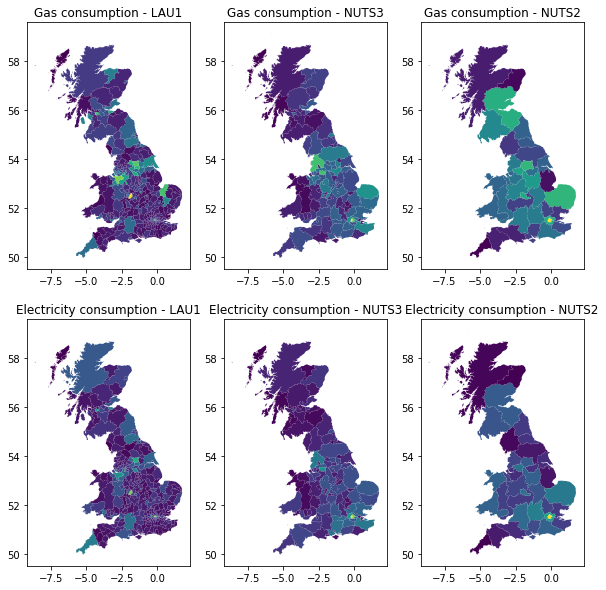

In [193]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
uk_lau1_units.plot('gas_con_nondom', ax=ax[0, 0])
ax[0, 0].set_title('Gas consumption - LAU1')
uk_lau1_units.dissolve('nuts3', aggfunc='sum').plot('gas_con_nondom', ax=ax[0, 1])
ax[0, 1].set_title('Gas consumption - NUTS3')
uk_lau1_units.dissolve('nuts2', aggfunc='sum').plot('gas_con_nondom', ax=ax[0, 2])
ax[0, 2].set_title('Gas consumption - NUTS2')
uk_lau1_units.plot('elec_con_nondom', ax=ax[1, 0])
ax[1, 0].set_title('Electricity consumption - LAU1')
uk_lau1_units.dissolve('nuts3', aggfunc='sum').plot('elec_con_nondom', ax=ax[1, 1])
ax[1, 1].set_title('Electricity consumption - NUTS3')
uk_lau1_units.dissolve('nuts2', aggfunc='sum').plot('elec_con_nondom', ax=ax[1, 2])
ax[1, 2].set_title('Electricity consumption - NUTS2')

# NUTS3 employment

[Eurostat data](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nama_10r_3empers.tsv.gz)

In [126]:
employment_df = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nama_10r_3empers.tsv.gz', delimiter='\t', index_col=0)
employment_df.index = employment_df.index.str.split(',', expand=True).rename(['unit', 'indicator', 'cat_name', 'region'])
employment_df.columns = employment_df.columns.astype(int)
employment_df = employment_df.apply(util.to_numeric)
employment_uk = employment_df.xs(('THS', 'EMP', 'B-E')).reindex(nuts3.id).loc[:, 2014]
employment_intensity = employment_uk.div(employment_uk.sum())

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [141]:
nuts3_2016 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2016_4326_LEVL_3.geojson')

In [155]:
foo = gpd.overlay(gpd.GeoDataFrame(data=nuts3_2016.id, geometry=nuts3_2016.to_crs('epsg:3035').centroid), nuts3.to_crs('epsg:3035'))
foo = foo.set_index('id_1')

In [163]:
foo['ind_employment'] = employment_df.xs(('THS', 'EMP', 'B-E')).reindex(foo.index)[2014]
foo['com_employment'] = employment_df.xs(('THS', 'EMP')).loc[['G-J', 'K-N', 'O-U']].sum(level='region').reindex(foo.index)[2014]

# Business statistics
[Eurostat structural business statistics](https://ec.europa.eu/eurostat/cache/metadata/en/sbs_esms.htm) and [business demography](https://data.europa.eu/euodp/en/data/dataset/UyhOw8gBOd7GmeYwB5unUw)

In [45]:
business_activity = pd.read_csv(data_path + '/industry/sbs_r_nuts06_r2.tsv', delimiter='\t', index_col=0)
business_activity.index = business_activity.index.str.split(',', expand=True).rename(['cat_code', 'indicator', 'region'])
business_activity.columns = business_activity.columns.astype(int)
business_activity = business_activity.apply(util.to_numeric)

industrial_activity_codes = pd.read_csv(
    data_path + '/industry/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

In [178]:
# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
business_activity_nuts2 = nuts2.copy(deep=True)
for business_code, activity in {'V11210': 'local_units', 'V16110': 'employees', 'V13320': 'wages'}.items():
    industry_activity = (
        business_activity
        .xs(business_code, level='indicator')
        .loc[idx[industrial_activity_codes['Eurostat sector'].dropna().index, uk_lau1_units.dropna().nuts2.unique()], :]
        .unstack()
        .groupby(industrial_activity_codes['Eurostat sector'].to_dict())
        .sum()
        .T
    )
    
    commercial_activity = (
        business_activity
        .xs(business_code, level='indicator')
        .loc[idx[['G', 'H', 'I', 'J', 'L', 'M', 'N', 'S95'], uk_lau1_units.dropna().nuts2.unique()], :]
        .sum(level=1)
    )
    
    business_activity_nuts2 = (
        business_activity_nuts2
        .merge(
            industry_activity.xs(2017).sum(axis=1)
            .div(industry_activity.xs(2017).sum().sum())
            .to_frame(f'industry_{activity}_intensity')
            .fillna(0), 
            left_on='id', right_index=True
        )
        .merge(
            commercial_activity[2017]
            .div(commercial_activity[2017].sum())
            .to_frame(f'commercial_{activity}_intensity')
            .fillna(0), 
            left_on='id', right_index=True
        )
    )

In [217]:
gas_nuts3 = uk_lau1_units.dissolve('nuts3', aggfunc='sum')['gas_con_nondom']

In [197]:
industry_energy_balances.loc['Commercial & public services'].div(industry_energy_balances.sum(level='carrier')).loc['Natural gas'] * gas_nuts3.sum()

77.53804746551367

In [218]:
com_gas_from_local_units = (
    foo.groupby('id_2').sum().reindex(gas_nuts3.index).com_employment.div(foo.groupby('id_2').sum().reindex(gas_nuts3.index).com_employment.sum()) * 
    industry_energy_balances.loc['Commercial & public services'].div(industry_energy_balances.sum(level='carrier')).loc['Natural gas'] *
    gas_nuts3.sum()
)

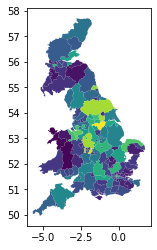

In [219]:
uk_lau1_units.dissolve('nuts3', aggfunc='sum').plot('gas_con_nondom')

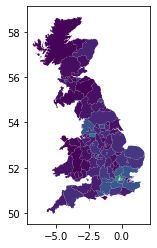

In [209]:
uk_lau1_units.dissolve('nuts3', aggfunc='sum').assign(gas_con_com=com_gas_from_local_units).plot('gas_con_com')

In [78]:
all_industrial_units = gpd.read_file('../build/all_industrial_ets_eprtr_sites.geojson')
# Map industries to Euro-calliope regions
industries_in_uk = gpd.overlay(all_industrial_units, nuts2)
regional_industry_emissions = industries_in_uk.groupby(['Subsector', 'id']).sum()[['emissions']]
regional_industry_emissions['emissions_intensity'] = (
    regional_industry_emissions['emissions'] / 
    regional_industry_emissions['emissions'].sum(level=['Subsector'])
)

In [81]:
regional_industry_emissions_gdf = nuts2.set_index('id').assign(emissions=regional_industry_emissions.sum(level=1)['emissions'])

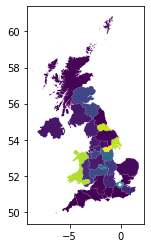

In [82]:
regional_industry_emissions_gdf.plot('emissions')